In [1]:
import sys
import os

package_path = '..'
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.config.config import load_config
config = load_config()
config.path.load_dir

'Y:\\240608_FXS\\raw_data\\h5\\type=raw'

In [4]:
from src.analyzer.loader import NpzLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from roi_rectangle import RoiRectangle

# Load Data

In [5]:
run_num: int = 43
print("run_num:", run_num)
npz_dir = config.path.npz_dir
npz_file = os.path.join(npz_dir, f"run={run_num:0>4}_scan=0001.npz")
_data = NpzLoader(npz_file).data
for key, values in _data.items():
    print(f"{key} shape: {values.shape}")


run_num: 43
pon shape: (60, 514, 1030)
poff shape: (60, 514, 1030)
delay shape: (60,)


In [6]:
pon_images = np.maximum(_data["pon"], 0)
poff_images = np.maximum(_data["poff"], 0)
delays = _data["delay"]
print("Pump Off Shape:", poff_images.shape)
print("Pump On Shape:", pon_images.shape)
print("Delays Shape:", delays.shape)

Pump Off Shape: (60, 514, 1030)
Pump On Shape: (60, 514, 1030)
Delays Shape: (60,)


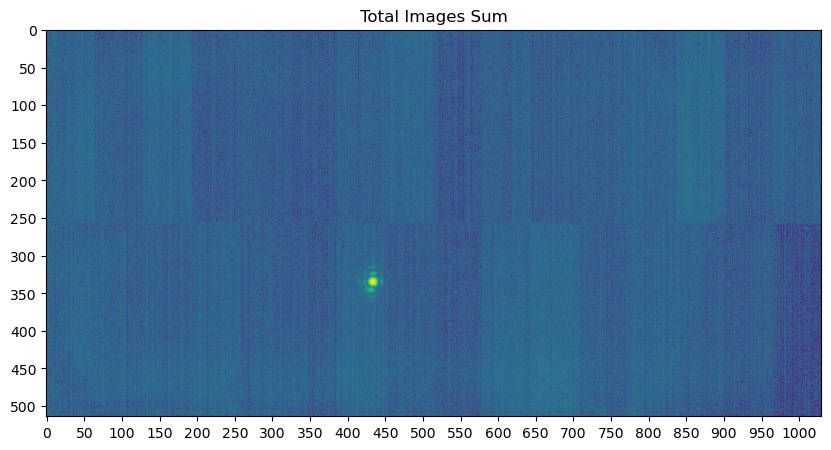

In [7]:
total_image_sum = np.sum(poff_images + pon_images, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(total_image_sum))
ax.set_title("Total Images Sum")
ax.set_yticks(np.arange(0, total_image_sum.shape[0], 50))
ax.set_xticks(np.arange(0, total_image_sum.shape[1], 50));

roi poff mean 1.221085
roi poff max 15.29716
roi pon mean 1.2103653
roi pon max 15.057066


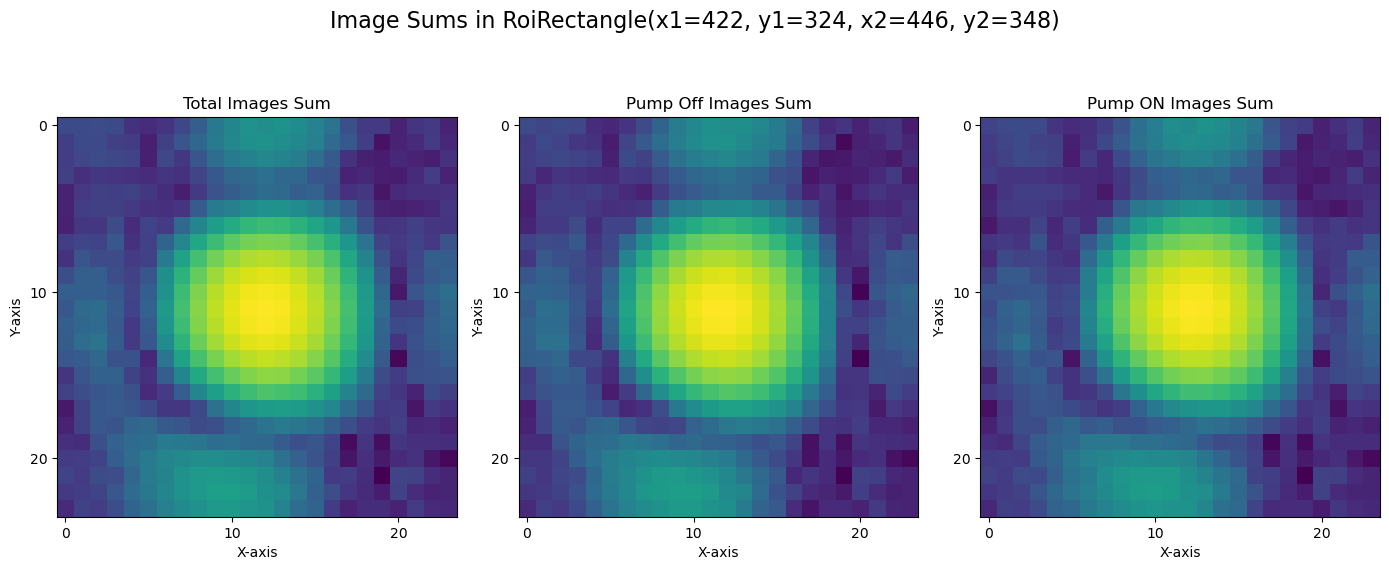

In [8]:
roi_rect = RoiRectangle(422, 324, 446, 348)
roi_image_sum = roi_rect.slice(total_image_sum)

roi_pons = roi_rect.slice(pon_images)
roi_poffs = roi_rect.slice(poff_images)

fig, ax = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle(f"Image Sums in {roi_rect}", fontsize=16)

ax[0].imshow(np.log1p(roi_image_sum), cmap='viridis')
ax[0].set_title(f"Total Images Sum")
ax[0].set_yticks(np.arange(0, roi_rect.height, 10))
ax[0].set_xticks(np.arange(0, roi_rect.width, 10))
ax[0].set_ylabel('Y-axis')
ax[0].set_xlabel('X-axis')

ax[1].imshow(np.log1p(roi_poffs.sum(0)), cmap='viridis')
ax[1].set_title(f"Pump Off Images Sum")
ax[1].set_yticks(np.arange(0, roi_rect.height, 10))
ax[1].set_xticks(np.arange(0, roi_rect.width, 10))
ax[1].set_ylabel('Y-axis')
ax[1].set_xlabel('X-axis')

ax[2].imshow(np.log1p(roi_pons.sum(0)), cmap='viridis')
ax[2].set_title(f"Pump ON Images Sum")
ax[2].set_yticks(np.arange(0, roi_rect.height, 10))
ax[2].set_xticks(np.arange(0, roi_rect.width, 10))
ax[2].set_ylabel('Y-axis')
ax[2].set_xlabel('X-axis')

plt.tight_layout()

print("roi poff mean", roi_poffs.mean())
print("roi poff max", roi_poffs.max())
print("roi pon mean", roi_pons.mean())
print("roi pon max", roi_pons.max())

In [36]:
from skimage.measure import moments, moments_central, shannon_entropy
from collections import defaultdict

def get_principal_axis(image):
    M = moments(image, order=2)
    cx = M[1, 0] / M[0, 0]
    cy = M[0, 1] / M[0, 0]

    mu = moments_central(image, center=(cx, cy), order=2)

    Ixx = mu[2, 0]
    Iyy = mu[0, 2]
    Ixy = -mu[1, 1]

    tensor = np.array([[Ixx, Ixy], [Ixy, Iyy]])

    eigenvalues, eigenvectors = np.linalg.eig(tensor)

    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]

    return principal_axis


def get_features(images) -> dict[str]:
    features = defaultdict(list)
    features["delay"] = list(delays)

    for image in images:

        M = moments(image, order=4)
        
        cx = M[1, 0] / M[0, 0]
        cy = M[0, 1] / M[0, 0]

        mu = moments_central(image, center=(cx, cy), order=4)

        sigma_x2 = mu[2, 0]
        sigma_y2 = mu[0, 2]

        sigma_x = np.sqrt(sigma_x2)
        sigma_y = np.sqrt(sigma_y2)

        gamma_1 = mu[3, 0] / (sigma_x**3)
        gamma_2 = mu[0, 3] / (sigma_y**3)

        beta_1 = mu[4, 0] / (sigma_x**4)
        beta_2 = mu[0, 4] / (sigma_y**4)
        
        principal_axis = get_principal_axis(image)
        orientation = np.arctan2(principal_axis[1], principal_axis[0])
        eccentricity = np.sqrt(1 - (min(sigma_x2, sigma_y2) / max(sigma_x2, sigma_y2)))
        aspect_ratio = max(sigma_x2, sigma_y2) / min(sigma_x2, sigma_y2)
        entropy = shannon_entropy(image)
        symmetry_y = np.sum(np.abs(image - np.flipud(image)))
        symmetry_x = np.sum(np.abs(image - np.fliplr(image)))
        azimuthal_profile = np.sum(image, axis=1)
        ring_completeness = np.std(azimuthal_profile) / np.mean(azimuthal_profile)

        features["intensity"].append(M[0, 0])
        features["centroid_x"].append(cx)
        features["centroid_y"].append(cy)
        features["spread_x"].append(sigma_x2)
        features["spread_y"].append(sigma_y2)
        features["skewness_x"].append(gamma_1)
        features["skewness_y"].append(gamma_2)
        features["kurtosis_x"].append(beta_1)
        features["kurtosis_y"].append(beta_2)
        features["principal_axis_x"].append(principal_axis[0])
        features["principal_axis_y"].append(principal_axis[1])
        features["orientation"].append(orientation)
        features["eccentricity"].append(eccentricity)
        features["aspect_ratio"].append(aspect_ratio)
        features["entropy"].append(entropy)
        features["symmetry_y"].append(symmetry_y)
        features["symmetry_x"].append(symmetry_x)

    return pd.DataFrame(features).set_index("delay")

poff_features = get_features(roi_poffs)
pon_features = get_features(roi_pons)

In [35]:
# poff_features = poff_features.loc[poff_features.index < 50]
# pon_features = pon_features.loc[pon_features.index < 50]

In [11]:
def plot_single_feature(poff_features: pd.DataFrame, pon_features: pd.DataFrame, key: str):
    
    title = key.title()
    fig, ax = plt.subplots(2, 1, figsize=(8, 10))
    fig.suptitle(f"Delay vs {title}", fontsize=16)

    ax[0].plot(poff_features.index, poff_features[key], "o-", label=f"Poff {title}")
    ax[0].plot(pon_features.index, pon_features[key], "x--", label=f"Pon {title}")
    ax[1].plot(poff_features.index, poff_features[key] - pon_features[key], "o-", label=f"Poff - Pon {title}")

    ax[0].set_xlabel("Delay", fontsize=14)
    ax[0].set_ylabel(title, fontsize=14)
    ax[1].set_xlabel("Delay", fontsize=14)
    ax[1].set_ylabel(title, fontsize=14)

    ax[0].legend(fontsize=12)
    ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    ax[1].legend(fontsize=12)
    ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout();

def plot_xy_feature_comparison(poff_features: pd.DataFrame, pon_features: pd.DataFrame, key: str):
    key_y = key + "_y"
    key_x = key + "_x"
    title = key.title()
    fig, ax = plt.subplots(4, 1, figsize=(8, 14))

    ax[0].plot(poff_features.index, poff_features[key_y], "o-", label=f"Poff {title} Y")
    ax[0].plot(pon_features.index, pon_features[key_y], "x--", label=f"Pon {title} Y")
    ax[1].plot(poff_features.index, poff_features[key_x], "o-", label=f"Poff {title} X")
    ax[1].plot(pon_features.index, pon_features[key_x], "x--", label=f"Pon {title} X")
    ax[2].plot(poff_features.index, poff_features[key_y] - pon_features[key_y], ".-", label=f"Poff - Pon {title} Y")
    ax[3].plot(poff_features.index, poff_features[key_x] - pon_features[key_x], ".-", label=f"Poff - Pon {title} X")

    fig.suptitle(f"Delay vs {title}", fontsize=16)
    fig.text(0.5, 0.92, f"Comparison of {title} Positions Between Poff and Pon", ha='center', fontsize=14)
    ax[0].set_title(f"{title} Y", fontsize=14)
    ax[1].set_title(f"{title} X", fontsize=14)
    ax[2].set_title(f"{title} Y Diff", fontsize=14)
    ax[3].set_title(f"{title} X Diff", fontsize=14)

    ax[0].set_ylabel(f"{title} Y", fontsize=14)
    ax[1].set_ylabel(f"{title} X", fontsize=14)
    ax[2].set_ylabel(f"{title} Y", fontsize=14)
    ax[3].set_ylabel(f"{title} X", fontsize=14)
    ax[3].set_xlabel("Delay", fontsize=14)

    ax[0].legend(fontsize=12)
    ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    ax[1].legend(fontsize=12)
    ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    ax[2].legend(fontsize=12)
    ax[2].grid(True, which='both', linestyle='--', linewidth=0.5)
    ax[3].legend(fontsize=12)
    ax[3].grid(True, which='both', linestyle='--', linewidth=0.5)

# Intensity

sum of all pixels in gray scale image

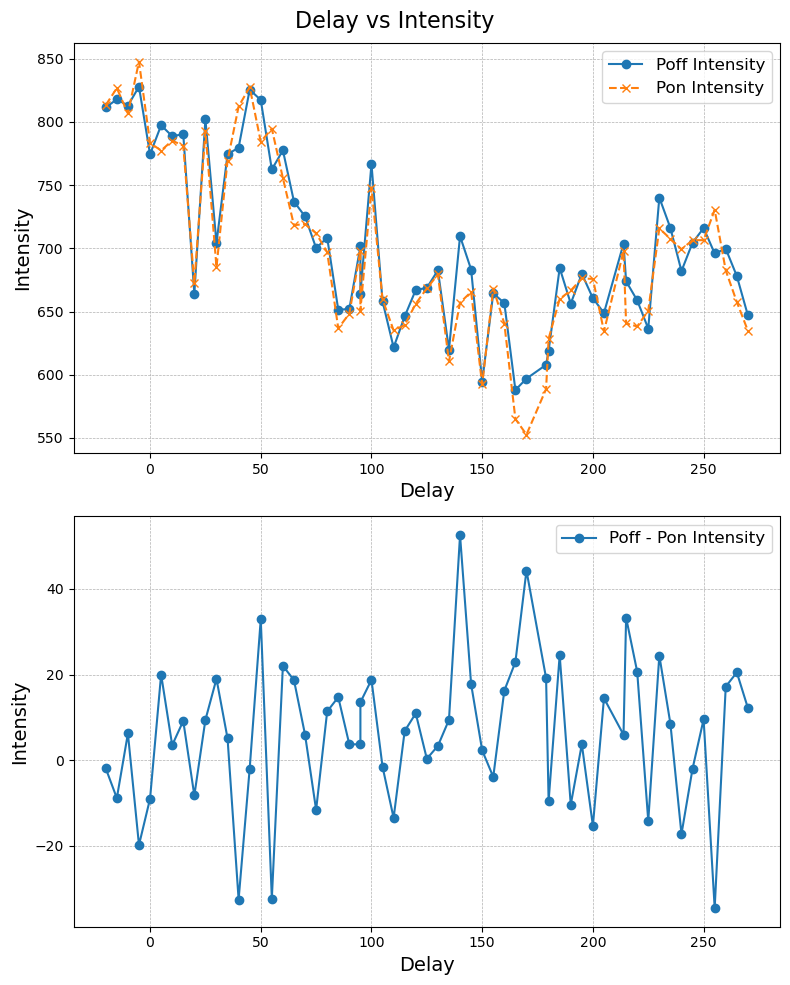

In [32]:
plot_single_feature(poff_features, pon_features, "intensity")

# Centroid

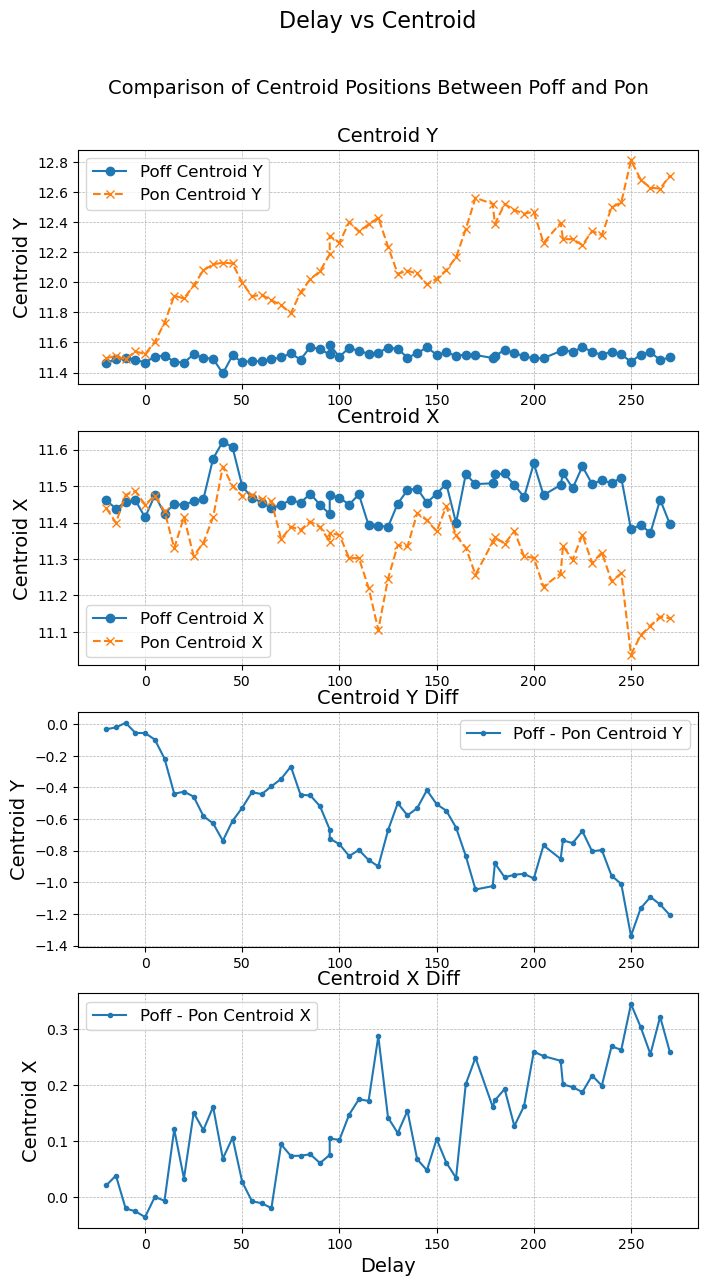

In [13]:
plot_xy_feature_comparison(poff_features, pon_features, "centroid")

## Spread
Spread, or dispersion, measures data variability.

It shows how data points are scattered around a central value.

Common measures include range, variance, and standard deviation.

Higher values indicate greater variability.

Understanding spread is crucial for data analysis and decision-making.

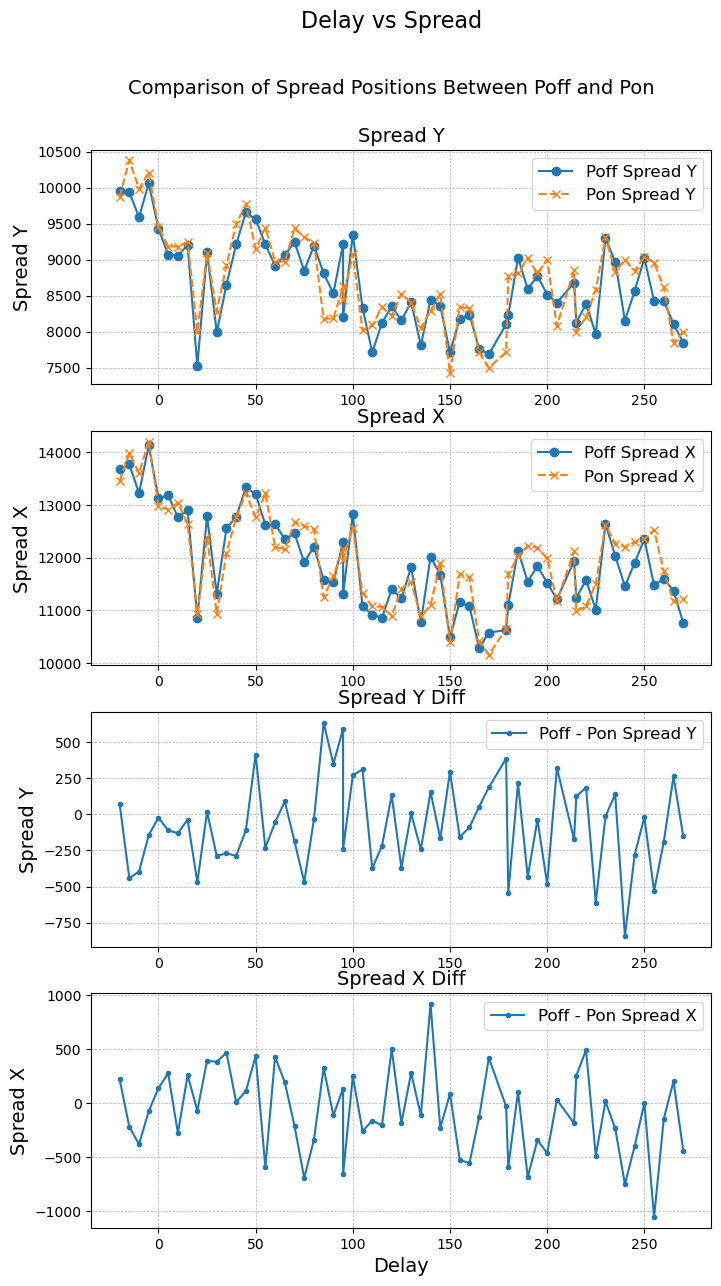

In [14]:
plot_xy_feature_comparison(poff_features, pon_features, "spread")

## Skewness
Skewness is a measure of the asymmetry of a data distribution.

It indicates symmetry when zero, right-skewed when positive, and left-skewed when negative.

This is crucial for assessing normality of data and in statistical modeling.

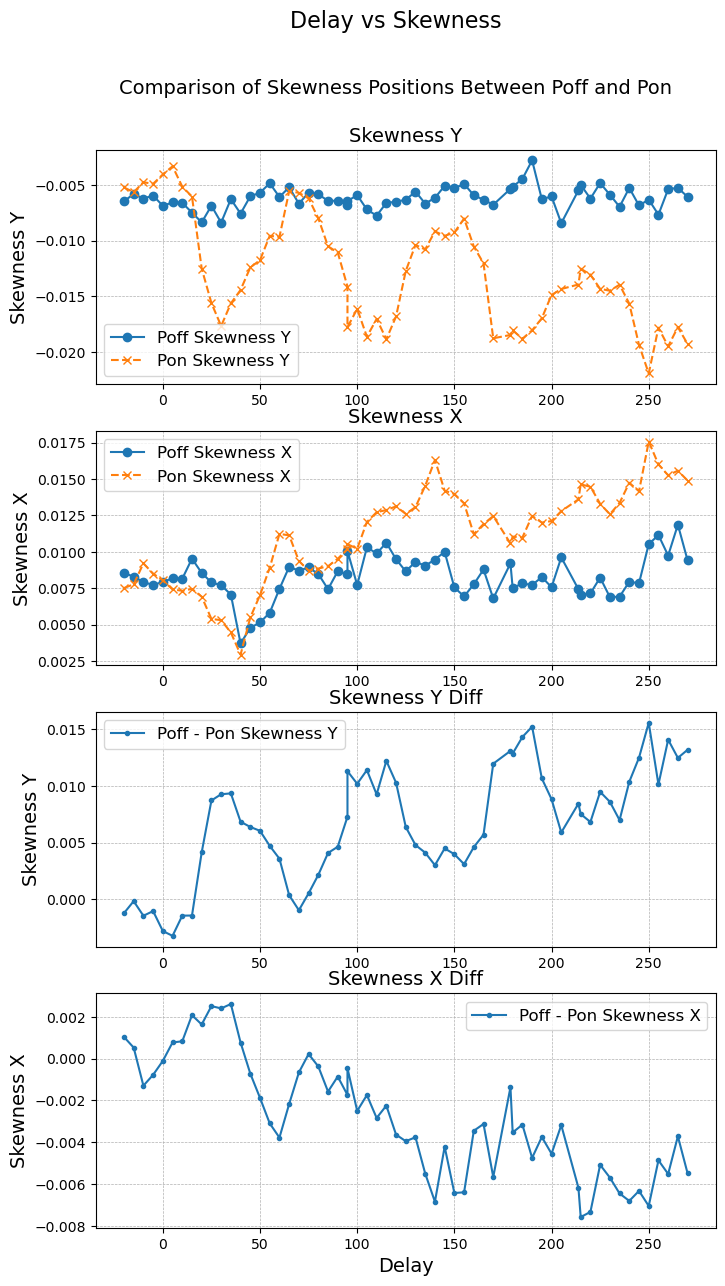

In [15]:
plot_xy_feature_comparison(poff_features, pon_features, "skewness")

## Kurtosis
Kurtosis measures the tailedness of a distribution, indicating the thickness of tails compared to a normal distribution.

Positive kurtosis (leptokurtic) means heavier tails and more extreme values, while negative kurtosis (platykurtic) means thinner tails and fewer extreme values.

It's crucial for understanding risk and volatility in data.

Kurtosis_x and kurtosis_y measure the sharpness of the image distribution, with values around 3 resembling a normal curve,

above 3 indicating a sharper peak, and below 3 suggesting a broader peak.

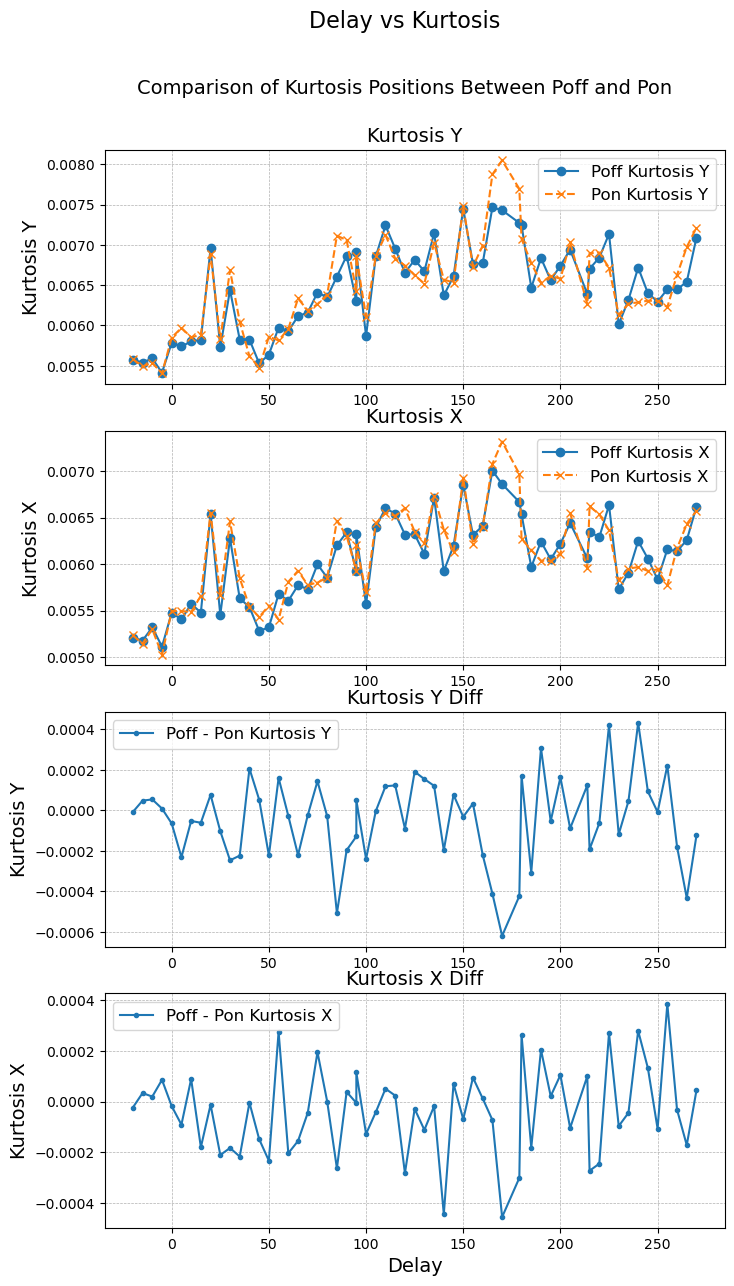

In [16]:
plot_xy_feature_comparison(poff_features, pon_features, "kurtosis")

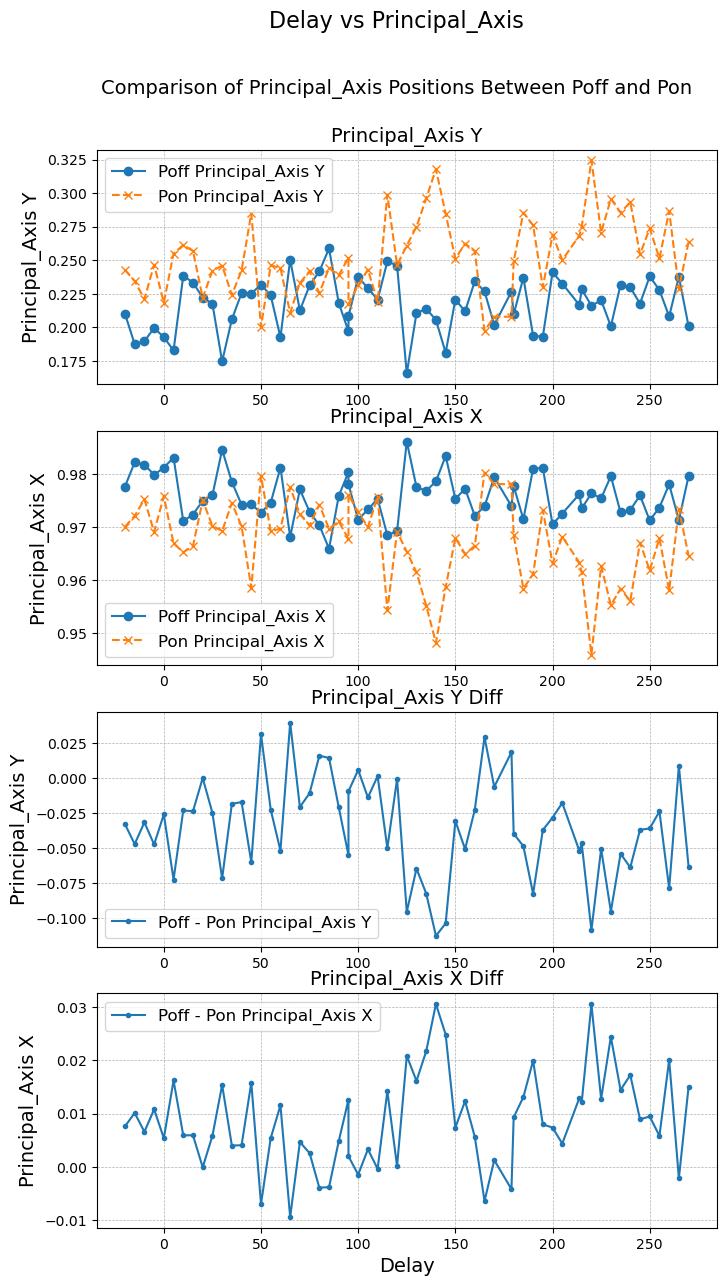

In [17]:
plot_xy_feature_comparison(poff_features, pon_features, "principal_axis")

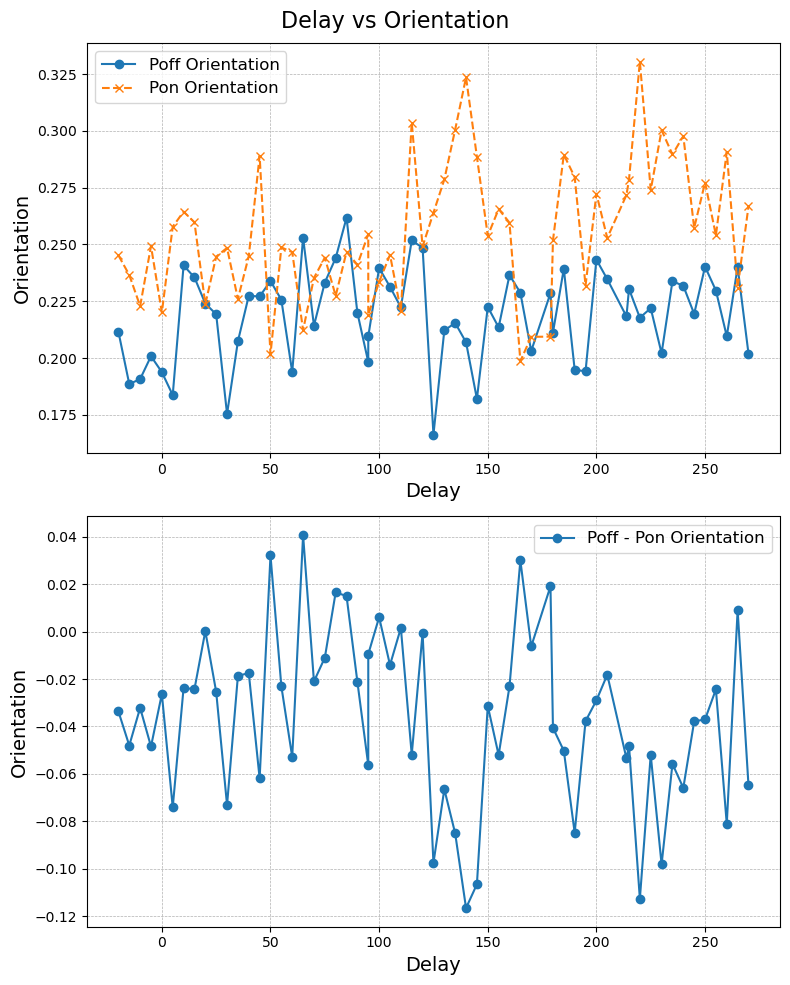

In [18]:
plot_single_feature(poff_features, pon_features, "orientation")

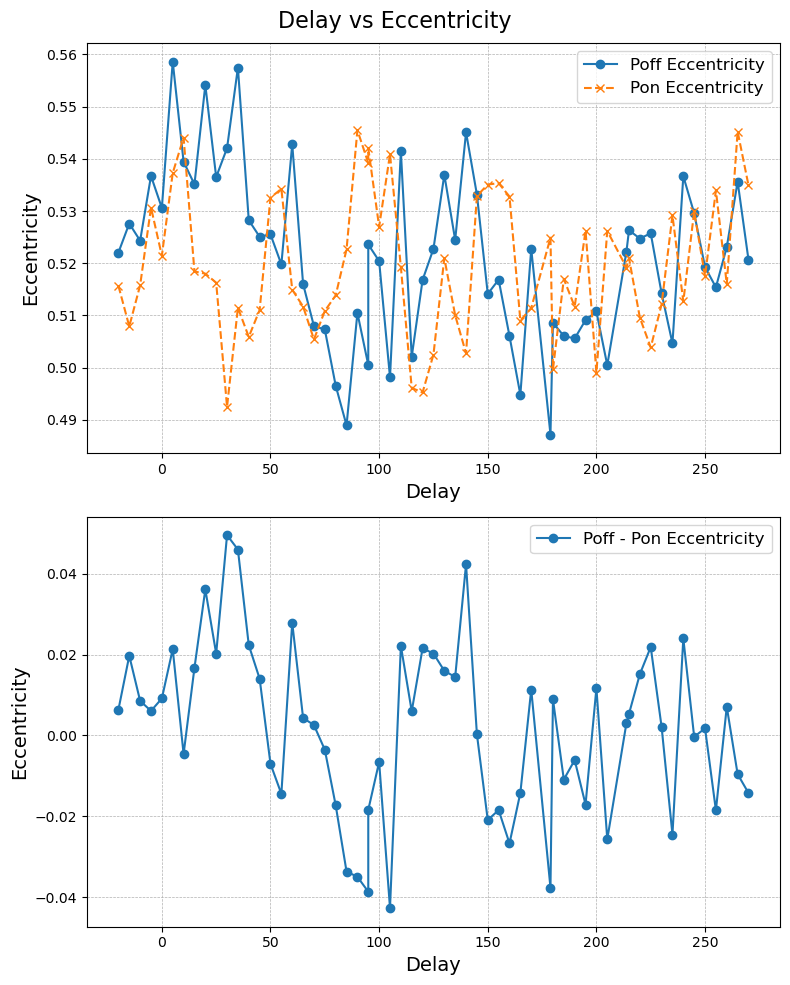

In [19]:
plot_single_feature(poff_features, pon_features, "eccentricity")

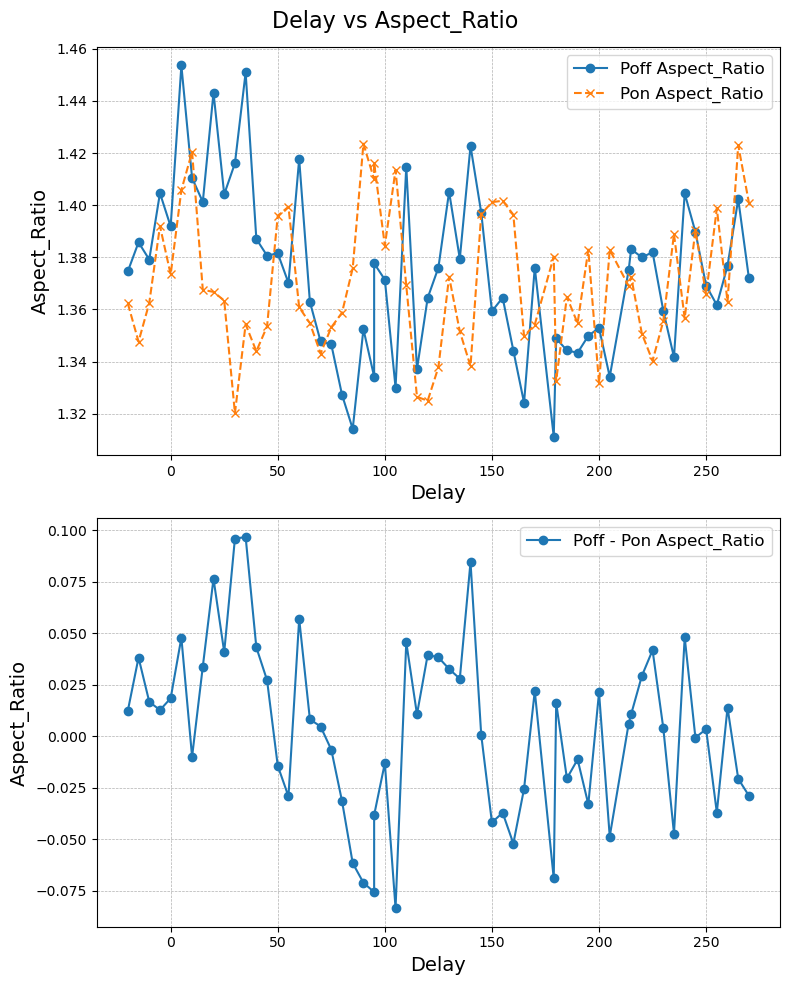

In [20]:
plot_single_feature(poff_features, pon_features, "aspect_ratio")

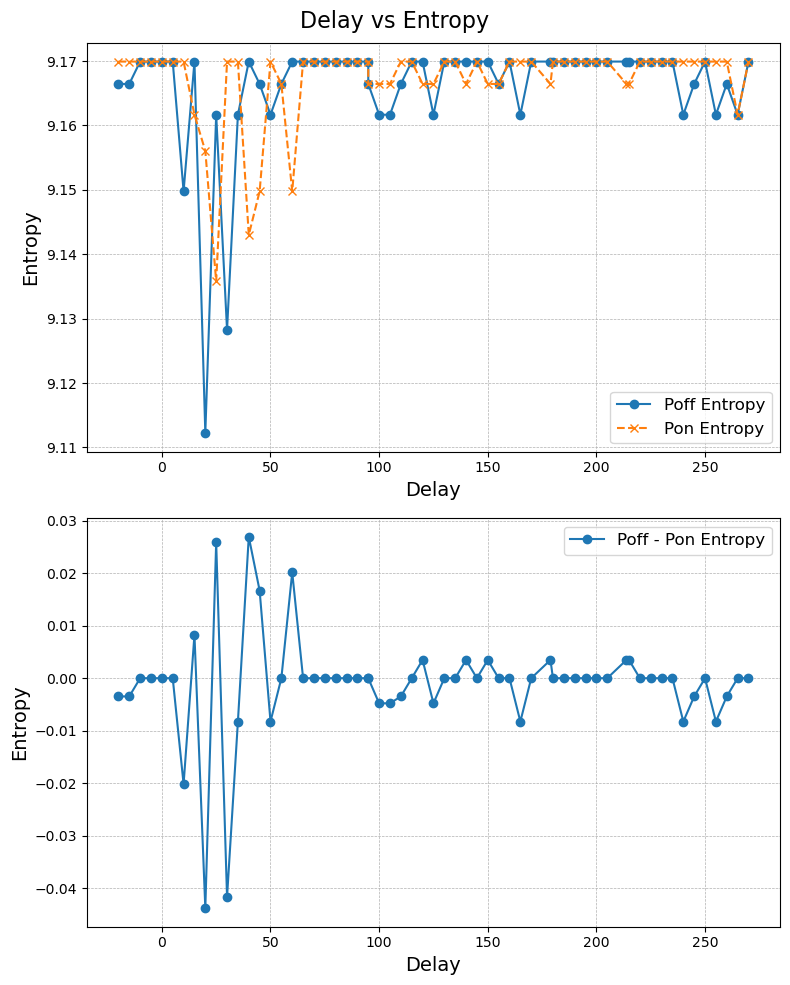

In [21]:
plot_single_feature(poff_features, pon_features, "entropy")

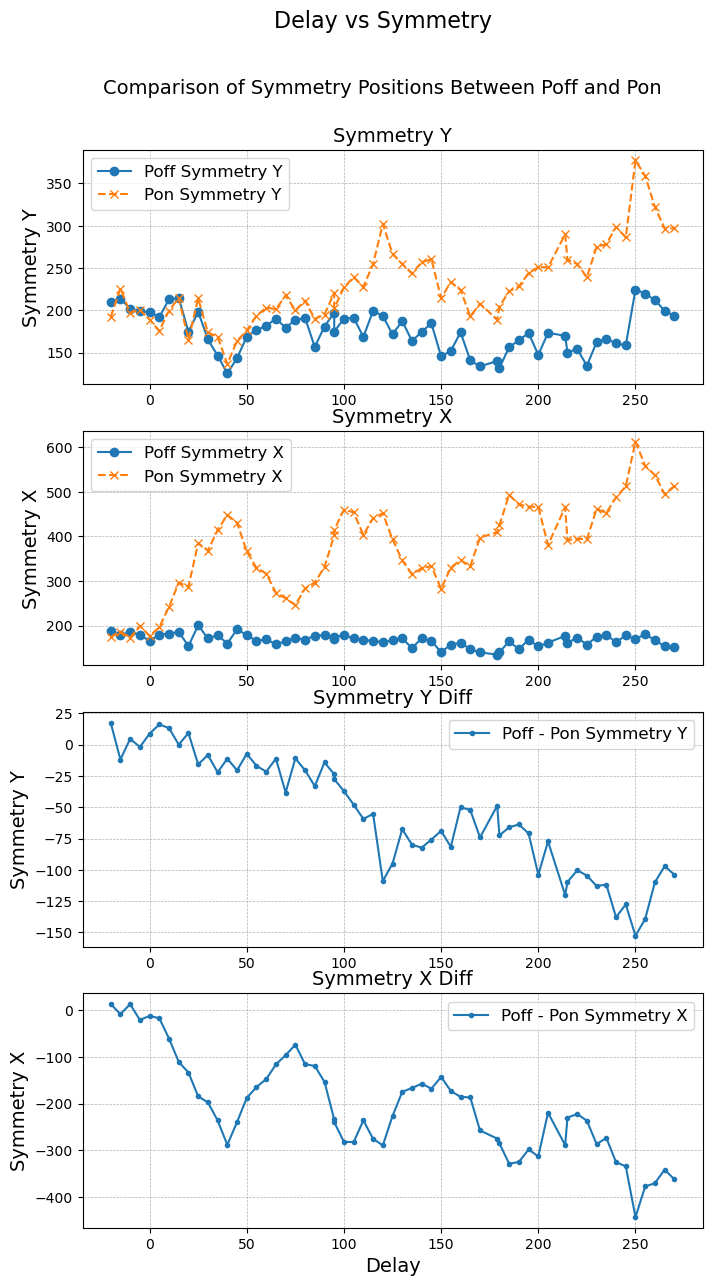

In [33]:
plot_xy_feature_comparison(poff_features, pon_features, "symmetry")